# Classifying Non Profit Donor Strategy from Cultivating Volunteers

**Sanjay Regi Philip and Maha Jayapal**

**Applied Data Science**

**Master’s Program**

**Shiley Marcos School of Engineering/ University of San Diego**

**sregiphilip@sandiego.edu | mjayapal@sandiego.edu**

### Purpose:
The purpose of this analytical research project is to leverage non profit volunteer databases to identify individuals who are likely to be high-level donors. As volunteer and donor data is highly sensitive information and a prized asset of non profit organizations, this research project uses data that is freely available and provided by the United States census which will need to be processed to only include features relevant for the topic of this research project.

## Data Retrieved from: 
https://archive.ics.uci.edu/ml/datasets/census+income

## Load Necessary Packages

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns

#!pip install dmba
import dmba
from dmba import classificationSummary, gainsChart, liftChart

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

%matplotlib inline
import matplotlib.pyplot as plt

no display found. Using non-interactive Agg backend


## Data Input

In [2]:
## Remember to replace with your local filepath
census = pd.read_csv('/Users/sanjay/Library/CloudStorage/OneDrive-Personal/USD/ADS599/Data/census.csv')

In [3]:
## keep copy of original dataframe in case we need to revert back later
census_original = census

## Data PreProcessing

In [4]:
## drop columns that are not likely to be valuable or relevant
census = census.drop(columns=['fnlwgt','education-num', 'capital-gain', 'capital-loss', 'hours-per-week',
                             'occupation', 'relationship', 'race'])

In [5]:
## drop '?' values
## The census dataset uses '?' in place of null values
census = census.drop(census.loc[census['workclass'] == '?'].index)
census = census.drop(census.loc[census['native-country'] == '?'].index)

In [6]:
## shape of the dataset after removing the null values
census.shape

(45232, 7)

### Encode Target Variable

In [7]:
## This project will be using income as the indicator for if someone is likely to be a mid-level or high-level donor
census['income'] = census['income'].replace({'<=50K': 'Mid-Level', '>50K': 'High-Level'})

### Process Categorical Variables

#### Process Marital Status

In [8]:
census['marital-status'] = census['marital-status'].replace({'Married-civ-spouse': 'Married', 
                                  'Married-spouse-absent': 'Married', 
                                  'Married-AF-spouse': 'Married'})
census['marital-status'].value_counts()

Married          21641
Never-married    14605
Divorced          6298
Separated         1411
Widowed           1277
Name: marital-status, dtype: int64

In [9]:
census['marital-status'] = census['marital-status'].replace({'Never-married': 'Single', 
                                  'Divorced': 'Single','Separated': 'Single', 'Widowed': 'Single'})
census['marital-status'].value_counts()

Single     23591
Married    21641
Name: marital-status, dtype: int64

#### Process Workclass

In [10]:
census['workclass'] = census['workclass'].replace({'Local-gov': 'Government', 
                                                   'Federal-gov': 'Government', 
                                                   'State-gov': 'Government',
                                                   
                                                   'Self-emp-not-inc': 'Self-emp',
                                                   'Self-emp-inc': 'Self-emp',
                                                   
                                                   'Without-pay': 'No-income',
                                                   'Never-worked': 'No-income',
                                                   
                                                   '?': 'Unknown'})

census['workclass'].value_counts()

Private       33307
Government     6452
Self-emp       5442
No-income        31
Name: workclass, dtype: int64

#### Process Native Country

In [11]:
census['native-country'] = np.where((census['native-country'] != 'United-States') & 
                                    (census['native-country'] != '?'), 'Non-US', census['native-country'])

census['native-country'] = census['native-country'].replace({'?': 'Unknown'})

census['native-country'].value_counts()

United-States    41302
Non-US            3930
Name: native-country, dtype: int64

#### Process Education

In [12]:
census['education'] = census['education'].replace({'10th': 'DNF HS', 
                                                   '7th-8th': 'DNF HS', 
                                                   '9th': 'DNF HS',
                                                   '11th': 'DNF HS', 
                                                   '9th': 'DNF HS',
                                                   '12th': 'DNF HS', 
                                                   '5th-6th': 'DNF HS',
                                                   '1st-4th': 'DNF HS', 
                                                   'Preschool': 'DNF HS',
                                                  
                                                   'HS-grad': 'HS',
                                                   'Some-college': 'HS',
                                                   
                                                   'Assoc-voc': 'Assoc',
                                                   'Assoc-acdm': 'Assoc'})

census['education'].value_counts()

HS             24686
Bachelors       7570
DNF HS          5667
Assoc           3466
Masters         2514
Prof-school      785
Doctorate        544
Name: education, dtype: int64

### Hot Encode Categorical Features

In [13]:
## saving a new dataframe with one hot encoding for categorical features
census_encoded = pd.get_dummies(data=census, columns=['workclass', 'education', 'marital-status', 'sex',
                                                     'native-country'])

In [14]:
## must remove one encoded column to avoid multicollinearity due to dummy variable trap
census_encoded = census_encoded.drop(columns=['workclass_Private', 'education_HS', 
                                             'marital-status_Single', 'sex_Male',
                                             'native-country_United-States'])

In [15]:
census_encoded.head()

,age,income,workclass_Government,workclass_No-income,workclass_Self-emp,education_Assoc,education_Bachelors,education_DNF HS,education_Doctorate,education_Masters,education_Prof-school,marital-status_Married,sex_Female,native-country_Non-US
0,25,Mid-Level,0,0,0,0,0,1,0,0,0,0,0,0
1,38,Mid-Level,0,0,0,0,0,0,0,0,0,1,0,0
2,28,High-Level,1,0,0,1,0,0,0,0,0,1,0,0
3,44,High-Level,0,0,0,0,0,0,0,0,0,1,0,0
5,34,Mid-Level,0,0,0,0,0,1,0,0,0,0,0,0


## Modeling

In [16]:
## Train/Split with 20% witheld for testing
train, test = train_test_split(census_encoded, test_size=0.2, random_state=42, stratify=census_encoded['income'])

## Used for column headers
census_X = census_encoded.drop(columns=['income'])

X_train = train.drop(columns=['income'])
X_test = test.drop(columns=['income'])

y_train = train['income']
y_test = test['income']

In [17]:
## Target Variable Classes
classes = ['High-Level', 'Mid-Level']

In [18]:
print('Shape of training features:', X_train.shape)
print('Shape of testing features:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training features: (36185, 13)
Shape of testing features: (9047, 13)
Shape of training label: (36185,)
Shape of training label: (9047,)


### Model Training and Hyperparameter Training

#### Logistic Regression

In [111]:
## Hyperparameter Tuning

# define models and parameters
model = LogisticRegression(max_iter = 10000000)

# hyperparameters
solvers = ['newton-cg', 'lbfgs', 'liblinear'] ## default lbfgs
penalty = ['l2'] ## default l2

# define grid search
grid = dict(solver=solvers,penalty=penalty)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.810695 using {'penalty': 'l2', 'solver': 'liblinear'}
0.810667 (0.004762) with: {'penalty': 'l2', 'solver': 'newton-cg'}
0.810557 (0.004630) with: {'penalty': 'l2', 'solver': 'lbfgs'}
0.810695 (0.004661) with: {'penalty': 'l2', 'solver': 'liblinear'}


In [54]:
## Save Logistic Regression Model with best hyperparamter performance
logit_regCV = LogisticRegressionCV(solver='liblinear', penalty='l2')
logit_regCV.fit(X_train, y_train)

LogisticRegressionCV(solver='liblinear')

#### Decision Tree

In [72]:
# define models and parameters
model = tree.DecisionTreeClassifier(random_state=1)

# hyperparameters
criterion = ['gini', 'entropy'] ## default gini
max_depth = [None, 5, 10, 20] ## default None
min_split = [2,5,10] ## default 2

# define grid search
grid = dict(criterion=criterion, max_depth=max_depth, min_samples_split=min_split)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.816416 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
0.801879 (0.006852) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
0.801879 (0.006852) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}
0.801879 (0.006852) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}
0.816029 (0.005709) with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
0.816084 (0.005596) with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
0.816416 (0.005678) with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
0.800691 (0.004496) with: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}
0.801327 (0.004252) with: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}
0.803427 (0.004112) with: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}
0.801548 (0.006060) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
0.801548 (0.006060) wit

In [73]:
## Save Decition Tree model with best hyperparamter performance
dtc = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 10, min_samples_split = 10, random_state=1)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=1)

#### Random Forest

(n_estimators) and the number of features considered for splitting at each leaf node (max_features)

In [74]:
# define models and parameters
model = RandomForestClassifier(random_state=1)

# hyperparameters
criterion = ['gini', 'entropy'] ## default gini
n_estimators = [100, 200, 300] ## default 100
max_features = ['sqrt', 'log2', None] ## default sqrt


# define grid search
grid = dict(criterion = criterion, n_estimators=n_estimators, max_features=max_features)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.805444 using {'criterion': 'entropy', 'max_features': None, 'n_estimators': 100}
0.804477 (0.004542) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
0.803980 (0.004732) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}
0.804809 (0.004681) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 300}
0.804477 (0.004542) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
0.803980 (0.004732) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 200}
0.804809 (0.004681) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 300}
0.805251 (0.005233) with: {'criterion': 'gini', 'max_features': None, 'n_estimators': 100}
0.804974 (0.005427) with: {'criterion': 'gini', 'max_features': None, 'n_estimators': 200}
0.805361 (0.005311) with: {'criterion': 'gini', 'max_features': None, 'n_estimators': 300}
0.804394 (0.004867) with: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_es

In [75]:
# Building Random Forest model with best performing hyperparameters
rf = RandomForestClassifier(criterion = 'entropy', max_features = None, n_estimators = 100, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=None, random_state=1)

#### Naive Bayes

In [77]:
# define models and parameters
model = GaussianNB()

# hyperparameters
var_smoothing = [0.00000001, 0.000000001, 0.0000000001] ## default 1e-9


# define grid search
grid = dict(var_smoothing = var_smoothing)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.781677 using {'var_smoothing': 1e-08}
0.781677 (0.016651) with: {'var_smoothing': 1e-08}
0.773525 (0.032578) with: {'var_smoothing': 1e-09}
0.764046 (0.051395) with: {'var_smoothing': 1e-10}


In [78]:
# Building Naive Bayes model with best performing hyperparameters
nb = GaussianNB(var_smoothing =1e-08)
nb.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-08)

#### KNN

In [83]:
## build model
model = KNeighborsClassifier()

n_neighbors =[5, 7] ## default 5
weights = ['uniform', 'distance'] # default uniform
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'] ## default auto

# define grid search
grid = dict(n_neighbors = n_neighbors, weights = weights, algorithm = algorithm)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

Best: 0.800470 using {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'}
0.791350 (0.005238) with: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
0.787205 (0.005470) with: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
0.795330 (0.004791) with: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
0.791239 (0.005332) with: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
0.792151 (0.005363) with: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}
0.787426 (0.005518) with: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
0.796711 (0.004952) with: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'uniform'}
0.791129 (0.005387) with: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'distance'}
0.791350 (0.005238) with: {'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'uniform'}
0.787205 (0.005470) with: {'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'distance'}
0.795

In [85]:
# Building KNN model 
knn = KNeighborsClassifier(algorithm = 'brute', n_neighbors = 7, weights = 'uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=7)

### Model Evlaluation

In [86]:
## function to calculate performance metrics
def evaluate_model(model, in_xtest, in_ytest):
    from sklearn import metrics

    # Test Data prediction 
    local_ypred = model.predict(in_xtest)

    # calculating accuracy, precision, recall, f1-score, and kappa score
    accuracy = round(metrics.accuracy_score(in_ytest, local_ypred),2)
    precision = round(metrics.precision_score(in_ytest, local_ypred, pos_label='High-Level'),2)
    recall = round(metrics.recall_score(in_ytest, local_ypred, pos_label='High-Level'),2)
    f1 = round(metrics.f1_score(in_ytest, local_ypred, pos_label='High-Level'),2)
    kappa = round(metrics.cohen_kappa_score(in_ytest, local_ypred),2)
    
    
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'f1': f1, 'Kappa': kappa}

In [96]:
## Logistic Regression Results
log_metric = evaluate_model(logit_regCV, X_test, y_test)
log_metric

{'Accuracy': 0.8, 'Precision': 0.67, 'Recall': 0.42, 'f1': 0.52, 'Kappa': 0.4}

In [97]:
## Decision Tree Results
dtc_metric = evaluate_model(dtc, X_test, y_test)
dtc_metric

{'Accuracy': 0.81,
 'Precision': 0.69,
 'Recall': 0.45,
 'f1': 0.54,
 'Kappa': 0.43}

In [98]:
## Random Forest Results
rf_metric = evaluate_model(rf, X_test, y_test)
rf_metric

{'Accuracy': 0.81,
 'Precision': 0.64,
 'Recall': 0.48,
 'f1': 0.55,
 'Kappa': 0.43}

In [95]:
## Naive Bayes Results
nb_metric = evaluate_model(nb, X_test, y_test)
nb_metric

{'Accuracy': 0.79, 'Precision': 0.59, 'Recall': 0.5, 'f1': 0.54, 'Kappa': 0.41}

In [92]:
## K Nearest Neighbor Results
knn_metric = evaluate_model(knn, X_test, y_test)
knn_metric

/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


{'Accuracy': 0.8, 'Precision': 0.62, 'Recall': 0.48, 'f1': 0.54, 'Kappa': 0.42}

In [104]:
## Visualize all performance measures together
performance = pd.DataFrame({'Logit':pd.Series(log_metric),'Decision Tree':pd.Series(dtc_metric),
                           'Random Forest':pd.Series(rf_metric),'Naive Bayes':pd.Series(nb_metric),
                           'K Nearest Neighbor':pd.Series(knn_metric)})

performance = performance.T

print("Model Performance")
print(performance)

Model Performance
                    Accuracy  Precision  Recall    f1  Kappa
Logit                   0.80       0.67    0.42  0.52   0.40
Decision Tree           0.81       0.69    0.45  0.54   0.43
Random Forest           0.81       0.64    0.48  0.55   0.43
Naive Bayes             0.79       0.59    0.50  0.54   0.41
K Nearest Neighbor      0.80       0.62    0.48  0.54   0.42


#### Model Evaluation Visual

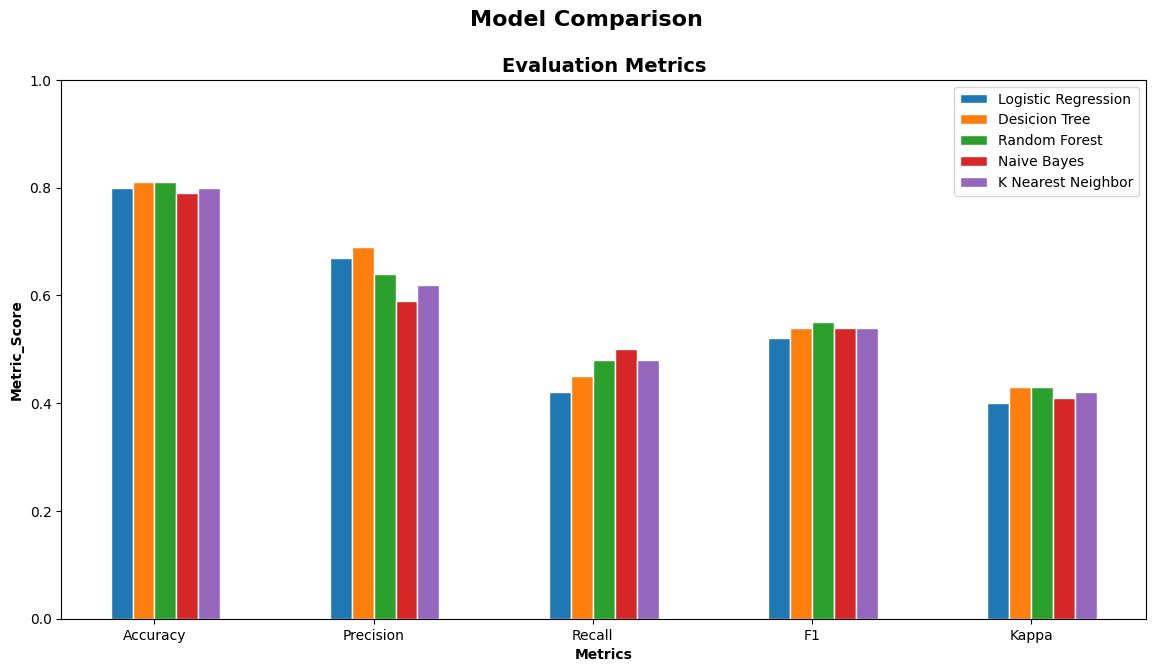

In [108]:
fig, (ax1) = plt.subplots(1)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)


barWidth = 0.1
log_score = [log_metric['Accuracy'], log_metric['Precision'], log_metric['Recall'], log_metric['f1'], log_metric['Kappa']]
dtc_score = [dtc_metric['Accuracy'], dtc_metric['Precision'], dtc_metric['Recall'], dtc_metric['f1'], dtc_metric['Kappa']]
rf_score = [rf_metric['Accuracy'], rf_metric['Precision'], rf_metric['Recall'], rf_metric['f1'], rf_metric['Kappa']]
nb_score = [nb_metric['Accuracy'], nb_metric['Precision'], nb_metric['Recall'], nb_metric['f1'], nb_metric['Kappa']]
knn_score = [knn_metric['Accuracy'], knn_metric['Precision'], knn_metric['Recall'], knn_metric['f1'], knn_metric['Kappa']]

r1 = np.arange(len(log_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]


ax1.bar(r1, log_score, width=barWidth, edgecolor='white', label='Logistic Regression')
ax1.bar(r2, dtc_score, width=barWidth, edgecolor='white', label='Desicion Tree')
ax1.bar(r3, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r4, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r5, knn_score, width=barWidth, edgecolor='white', label='K Nearest Neighbor')


## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Metric_Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

plt.show()